

```
Please change runtime type as GPU
```



#`"Finding and Measuring Lungs in CT Data"`

![CT](https://www.andersondiagnostics.com/wp-content/uploads/2017/09/CT-Scanner.jpg)

## DESCRIZIONE
**Context**\
Competitions like [LUNA](http://luna16.grand-challenge.org) and the [Kaggle Data Science Bowl 2017](https://www.kaggle.com/c/data-science-bowl-2017) involve processing and trying to find lesions in CT images of the lungs. In order to find disease in these images well, it is important to first find the lungs well. This dataset is a collection of 2D and 3D images with manually segmented lungs.

**Challenge**\
Come up with an algorithm for accurately segmenting lungs and measuring important clinical parameters (lung volume, PD, etc)

**Percentile Density (PD)**\
The PD is the density (in Hounsfield units) the given percentile of pixels fall below in the image. The table includes 5 and 95% for reference. For smokers this value is often high indicating the build up of other things in the lungs.

> URL: [kaggle.com](https://www.kaggle.com/kmader/finding-lungs-in-ct-data)

![CT types](https://www.radiologycafe.com/images/basics/ct-planes.png)

## Importazione del dataset

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.mkdir('./input')
!unzip -q "/content/drive/My Drive/Corso ML/7. CNN/CT_lungs_data.zip" -d "./input"

In [0]:
BASE_PATH = './input'
IMAGE_LIB = f'{BASE_PATH}/2d_images'
MASK_LIB = f'{BASE_PATH}/2d_masks'

In [0]:
df = pd.read_csv(f'{BASE_PATH}/lung_stats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 7 columns):
img_id                  267 non-null object
lung_area_px            267 non-null int64
lung_area_mm2           267 non-null float64
lung_volume_fraction    267 non-null float64
lung_mean_hu            267 non-null float64
lung_pd95_hu            267 non-null float64
lung_pd05_hu            267 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.7+ KB


In [0]:
df['img_path'] = df['img_id'].apply(lambda x: f'{IMAGE_LIB}/{x}')
df['mask_path'] = df['img_id'].apply(lambda x: f'{MASK_LIB}/{x}')

print(len(df), 'matching files found.')

267 matching files found.


In [0]:
df.head()

,img_id,lung_area_px,lung_area_mm2,lung_volume_fraction,lung_mean_hu,lung_pd95_hu,lung_pd05_hu,img_path,mask_path
0,ID_0000_Z_0142.tif,57342,40318.593750,0.218742,-644.750671,-368.00,-798.0,./input/2d_images/ID_0000_Z_0142.tif,./input/2d_masks/ID_0000_Z_0142.tif
1,ID_0001_Z_0146.tif,95955,67468.359375,0.366039,-720.042978,-544.00,-847.0,./input/2d_images/ID_0001_Z_0146.tif,./input/2d_masks/ID_0001_Z_0146.tif
2,ID_0002_Z_0162.tif,60782,42737.343750,0.231865,-616.722632,-294.00,-777.0,./input/2d_images/ID_0002_Z_0162.tif,./input/2d_masks/ID_0002_Z_0162.tif
3,ID_0003_Z_0132.tif,52852,37161.562500,0.201614,-664.036441,-267.55,-851.0,./input/2d_images/ID_0003_Z_0132.tif,./input/2d_masks/ID_0003_Z_0132.tif
4,ID_0004_Z_0066.tif,81260,57135.937500,0.309982,-675.347969,-295.00,-842.0,./input/2d_images/ID_0004_Z_0066.tif,./input/2d_masks/ID_0004_Z_0066.tif


In [0]:
def plot_ct_data(img_path, mask_path, area_px=None, area_mm2=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    img = imread(img_path)
    ax[0].imshow(img)
    ax[0].set_title(img_path)

    mask = imread(mask_path)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Manually Segmented Mask')

    plt.suptitle(f'Lung CT Image {img.shape}\nArea: {area_px} px / {area_mm2:.1f} mm2', fontsize=16)
    plt.show()

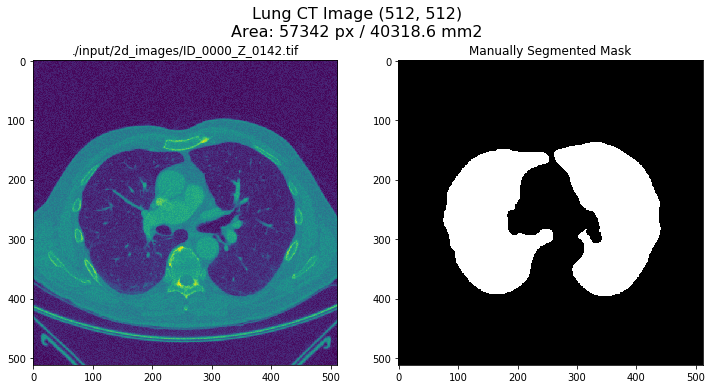

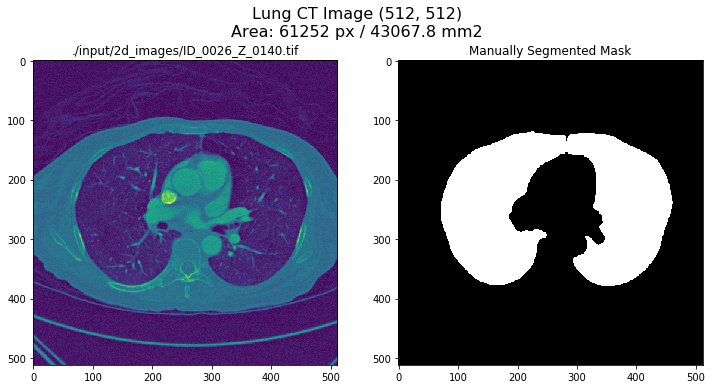

In [0]:
for i in range(2):
    rnd = df.sample()

    plot_ct_data(rnd['img_path'].values[0], 
                rnd['mask_path'].values[0], 
                area_px=rnd.lung_area_px.values[0],
                area_mm2=rnd.lung_area_mm2.values[0])

The images have only one channel.

## Training

In [0]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


**Train/Validation/Test Split**

In [0]:
TEST_SIZE = 0.10
VALID_SIZE = 0.30

In [0]:
# df.sample(frac=1) shuffles the dataframe
df_train, df_valid, df_test = np.split(df.sample(frac=1), [int((1 - VALID_SIZE - TEST_SIZE) * len(df)), int((1 - TEST_SIZE) * len(df))])

print(f'Training size    : {len(df_train):8d} ({len(df_train)/len(df):.1%})')
print(f'Validation size  : {len(df_valid):8d} ({len(df_valid)/len(df):.1%})')
print(f'Test size        : {len(df_test):8d} ({len(df_test)/len(df):.1%})')

Training size    :      160 (59.9%)
Validation size  :       80 (30.0%)
Test size        :       27 (10.1%)


### Data Augumentation

**Training Generator**

In [0]:
def train_generator(df, batch_size=32, img_size=(256, 256)):
    SEED = np.random.randint(0, 10000)

    # Try: samplewise_center, samplewise_std_normalization
    datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=15,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 zoom_range=0.05,
                                 fill_mode='nearest',
                                 horizontal_flip=True,
                                 vertical_flip=True)
    
    data_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='img_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None,
                                                 color_mode='grayscale',
                                                 seed=SEED)
    
    mask_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='mask_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None,
                                                 color_mode='grayscale',
                                                 seed=SEED)    
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

**Validation Generator**

In [0]:
def valid_generator(df, batch_size=32, img_size=(256, 256)):
    SEED = np.random.randint(0, 10000)

    datagen = ImageDataGenerator(rescale=1./255)
    
    data_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='img_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None, 
                                                 color_mode='grayscale',
                                                 seed=SEED)
    
    mask_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='mask_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None, 
                                                 color_mode='grayscale',
                                                 seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

**Example of Augumentation**

Found 160 validated image filenames.
Found 160 validated image filenames.


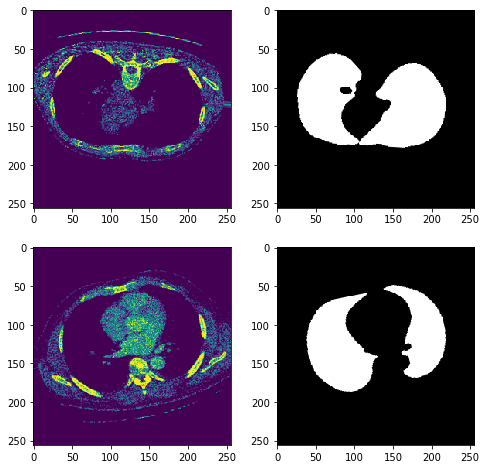

In [0]:
image_batch, mask_batch = next(train_generator(df_train))
fix, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[i,0].imshow(image_batch[i, :, :, 0])
    ax[i,1].imshow(mask_batch[i, :, :, 0], cmap='gray')
plt.show()

### Model Definition

In [0]:
import keras.backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from IPython.display import Image
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

**Loss function**

Losses : https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

**U-Net model**

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, second = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor) #He initialization works better for layers with ReLu activation
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    if second: 
        x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                   kernel_initializer = 'he_normal', padding = 'same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    return x

In [0]:
# 2D u-net model with either up-convolution or up-sampling and Batchnormalization or not

def build_2D_unet(input_img, n_filters=16, growth_factor=2, upconv=True, batchnorm=True, second=True, dropout=True):

    assert input_img.ndim == 4
    assert type(n_filters) == int and type(growth_factor) == int
    
    droprate = 0.20
    input_layer = Input(shape=input_img.shape[1:])

    ######## -----  ENCODER PART  ----- #########
    conv1 = conv2d_block(input_layer, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    Pool1 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv1)

    n_filters *= growth_factor #64
    conv2 = conv2d_block(Pool1, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    Pool2 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv2)
    if dropout:
        Pool2 = Dropout(droprate)(Pool2)

    n_filters *= growth_factor #128
    conv3 = conv2d_block(Pool2, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    Pool3 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv3)
    if dropout:
        Pool3 = Dropout(droprate)(Pool3)

    n_filters *= growth_factor #256
    conv4 = conv2d_block(Pool3, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    Pool4 = MaxPool2D(pool_size=(2, 2), strides=(2,2))(conv4)
    if dropout:
        Pool4 = Dropout(droprate)(Pool4)
    
    ######## -----  BOTTLENECK  ----- #########
    n_filters *= growth_factor #512
    conv5 = conv2d_block(Pool4, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)

    ######## -----  DECODER PART  ----- #########
    n_filters //= growth_factor #256
    if upconv:
        convT1 = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=(2, 2), padding='same')(conv5) #256 features
        cat1 = concatenate([conv4, convT1], axis=-1) #512 features
    else:
        cat1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = conv2d_block(cat1, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    if dropout:
        conv6 = Dropout(droprate)(conv6)
        
    n_filters //= growth_factor #128
    if upconv:
        convT2 = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=(2, 2), padding='same')(conv6) #128 features
        cat2 = concatenate([conv3, convT2], axis=-1) #256 features
    else:
        cat2 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = conv2d_block(cat2, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    if dropout:
        conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor #64
    if upconv:
        convT3 = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=(2, 2), padding='same')(conv7) #64 features
        cat3 = concatenate([conv2, convT3], axis=-1) #128 features
    else:
        cat3 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])    
    conv8 = conv2d_block(cat3, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    if dropout:
        conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor #32
    if upconv:
        convT4 = Conv2DTranspose(n_filters, kernel_size=(2,2), strides=(2, 2), padding='same')(conv8) #32 features
        cat4 = concatenate([conv1, convT4], axis=-1) #64 features
    else:
        cat4 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])    
    conv9 = conv2d_block(cat4, n_filters, kernel_size = 3, batchnorm = batchnorm, second = second)
    
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(conv9)
                                                             
    return Model(input_layer, output_layer)

**Build the Model**

In [0]:
model = build_2D_unet(next(train_generator(df_train))[0], 
                      n_filters=16, 
                      growth_factor=2, 
                      upconv=True, 
                      batchnorm=False,
                      second=False,
                      dropout=False)

Found 160 validated image filenames.
Found 160 validated image filenames.







**Compile the Graph**

In [0]:
model.compile(optimizer=Adam(lr=1e-3), 
              loss='binary_crossentropy', 
              metrics=[dice_coef])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 16) 0           activation_1[0][0]               
____________________________________________________________________________________________

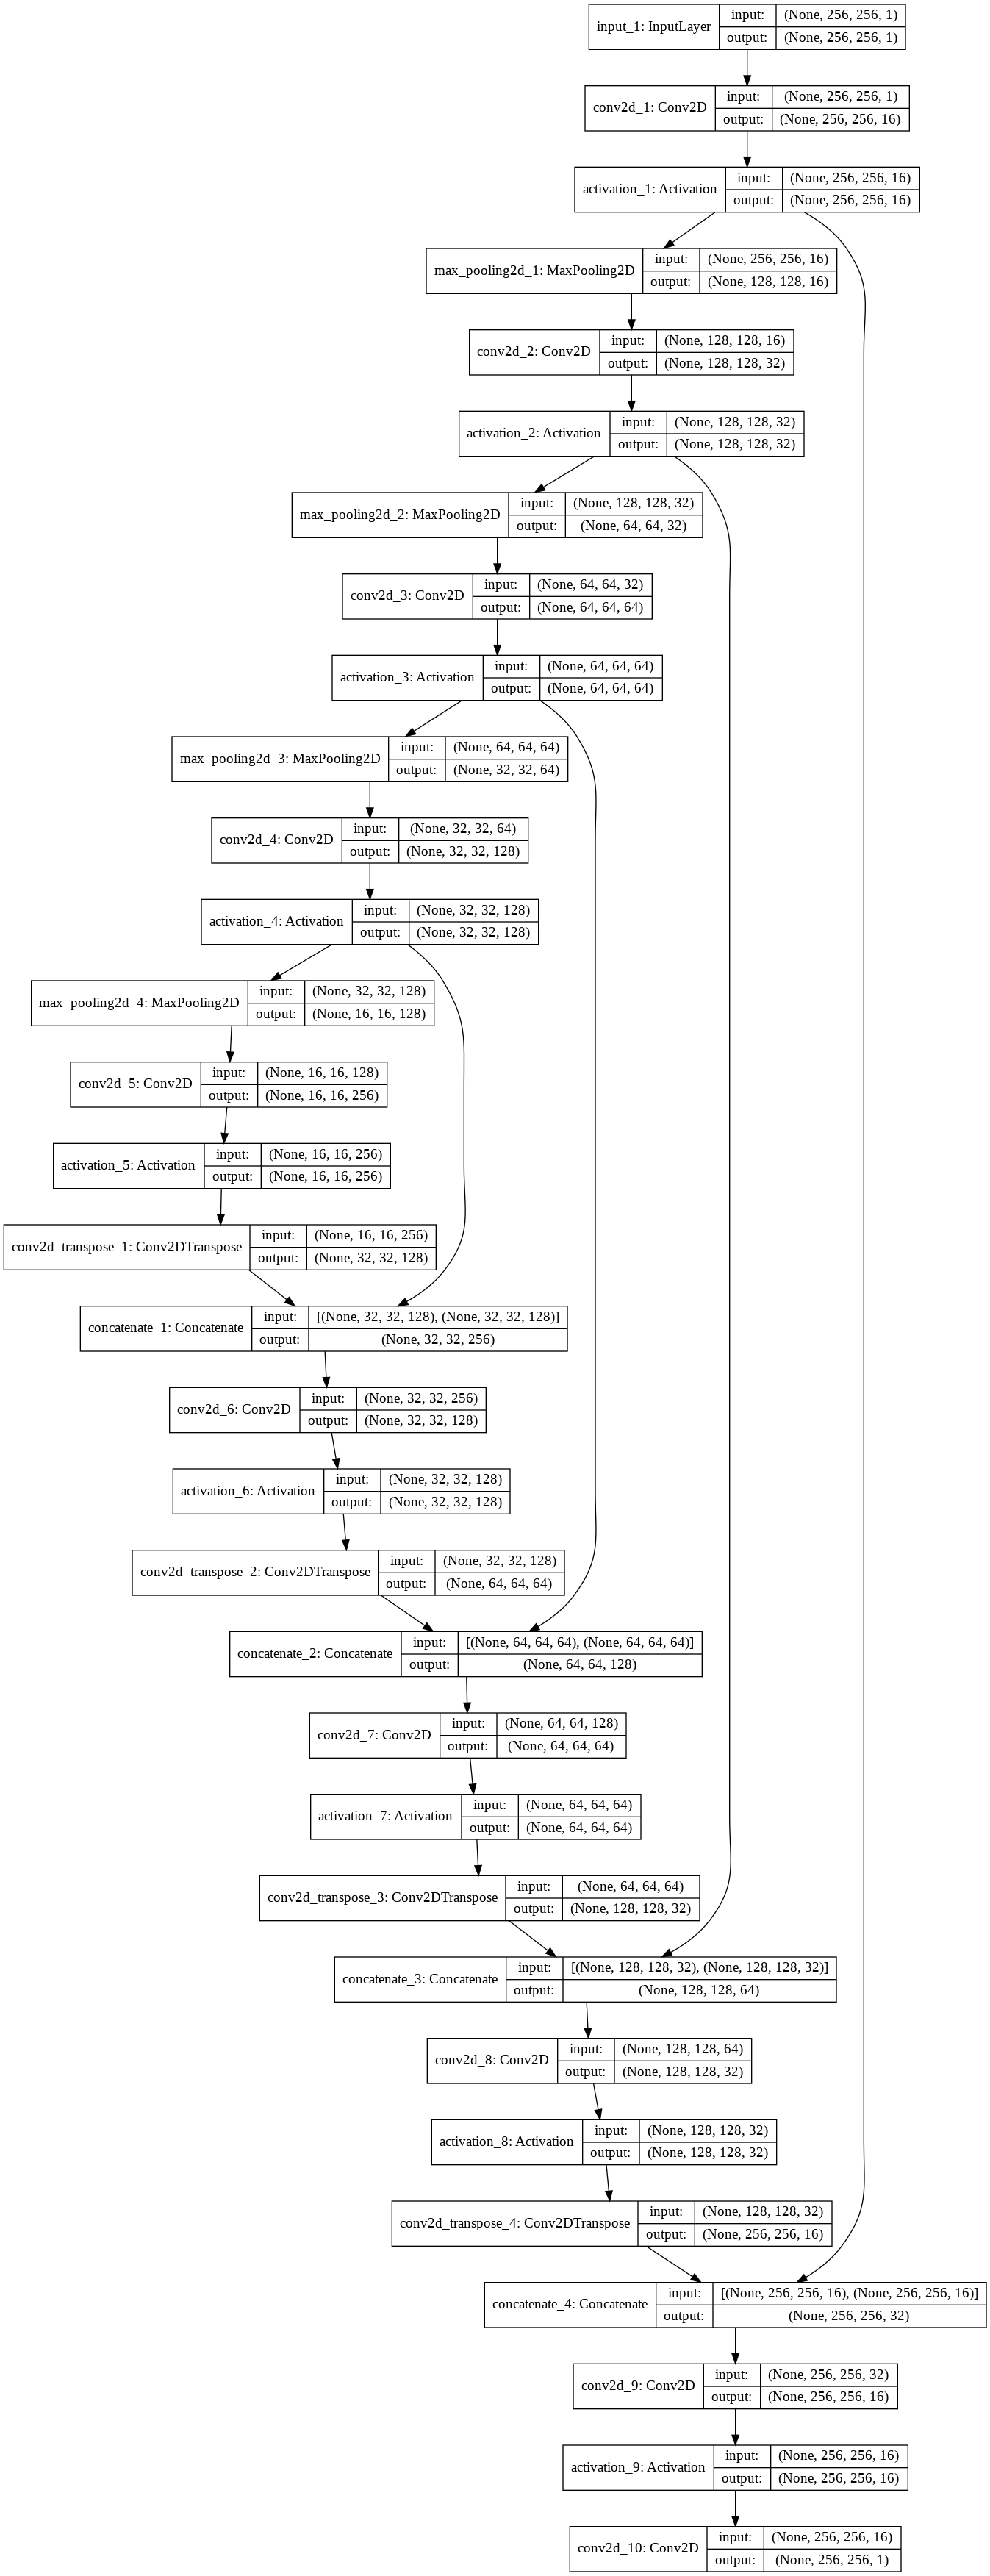

In [0]:
plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
Image('test_keras_plot_model.png')

### Training

**Hyper-parameters**

In [0]:
# Halves the resolution of the images (original size is (512,512))
IMG_HEIGHT, IMG_WIDTH = 256, 256

BATCH_SIZE = 32
EPOCHS = 50

**Callbacks**

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5,
                              patience=5,
                              min_lr=1e-6, 
                              verbose=1)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

**Train**

In [0]:
history = model.fit_generator(train_generator(df_train, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)), 
                              steps_per_epoch=max(1, len(df_train) // BATCH_SIZE),
                              validation_data=valid_generator(df_valid, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)), 
                              validation_steps=max(1, len(df_valid) // BATCH_SIZE), 
                              callbacks=[reduce_lr, checkpoint],
                              epochs=EPOCHS)




Epoch 1/50
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 160 validated image filenames.
Found 160 validated image filenames.





5/5 [==============================] - 12s 2s/step - loss: 0.6315 - dice_coef: 0.2895 - val_loss: 0.5463 - val_dice_coef: 0.3101
Epoch 2/50
5/5 [==============================] - 1s 144ms/step - loss: 0.5518 - dice_coef: 0.3169 - val_loss: 0.5108 - val_dice_coef: 0.3078
Epoch 3/50
5/5 [==============================] - 0s 96ms/step - loss: 0.5767 - dice_coef: 0.2946 - val_loss: 0.4485 - val_dice_coef: 0.3612
Epoch 4/50
5/5 [==============================] - 2s 300ms/step - loss: 0.5188 - dice_coef: 0.3272 - val_loss: 0.4124 - val_dice_coef: 0.4263
Epoch 5/50
5/5 [==============================] - 2s 360ms/step - loss: 0.4473 - dice_coef: 0.3884 - val_loss: 0.3233 - val_dice_coef: 0.4499
Epoch 6/50
5/5 [==============================] - 2s 372ms/step - loss: 0.4279 - dice_coef: 0.3956 - val_loss: 0.3462 - val_dice_coef: 0.46

### Training History

In [0]:
# Define a smooth function to display the training and validation curves
def plot_learning_curves(hist):
    val_loss = hist.history['val_loss']
    loss = hist.history['loss']
    dice_coef = hist.history['dice_coef']
    val_dice_coef = hist.history['val_dice_coef']
    
    epochs = range(1, len(loss)+1 )
    
    # Plot the loss and accuracy curves for training and validation 
    fig, ax = plt.subplots(2,1, figsize=(8, 12))
    ax[0].plot(epochs, loss, 'b', label="Training loss")
    ax[0].plot(epochs, val_loss, 'r', label="Validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(epochs, dice_coef, 'b', label="Training dice coeff")
    ax[1].plot(epochs, val_dice_coef, 'r',label="Validation dice coeff")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Dice coeff')
    return

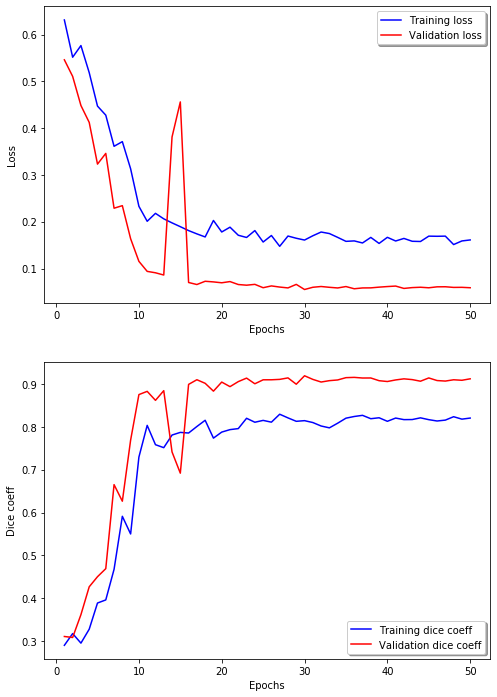

In [0]:
# Visualisation
plot_learning_curves(history)

## Testing

**Load best model**

In [0]:
from keras.models import load_model

# The best model according to val_loss
model = load_model('model.h5', custom_objects={'dice_coef': dice_coef})

### Test Set Evaluation

In [0]:
loss, dice_coeff = model.evaluate_generator(valid_generator(df_test, batch_size=1, img_size=(IMG_HEIGHT, IMG_WIDTH)), steps=len(df_test))
print(f'Test loss        : {loss:6.3f}')
print(f'Test Dice coeff. : {dice_coeff:6.3f}')

Found 27 validated image filenames.
Found 27 validated image filenames.
Test loss        :  0.059
Test Dice coeff. :  0.906


### Test Set Predictions

In [0]:
def test_generator(df, batch_size=32, img_size=(256, 256)):
    datagen = ImageDataGenerator(rescale=1./255)
    
    data_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='img_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None, 
                                                 color_mode='grayscale',
                                                 shuffle=False) # <- Testing
    
    mask_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 x_col='mask_path',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode=None, 
                                                 color_mode='grayscale',
                                                 shuffle=False) # <- Testing
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

In [0]:
# Dataset where to save predictions and metrics
df_test_pred = df_test.copy()
data = {'accuracy': [],
        'true_lung_px': [],
        'recognized_lung_px': [],
        'perc_recognized_lung_px': [],
        'true_background_px': [],
        'recognized_background_px': [],
        'perc_recognized_background_px': []}

In [0]:
idx = 0
for img, mask in test_generator(df_test, batch_size=1, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    # Predict
    mask_pred = model.predict(img)

    # Trasfom images to the right size
    mask = mask[0, : , :, 0]
    mask_pred = mask_pred[0, : , :, 0]

    # Round all values to 0 or 1
    mask_pred = np.round(mask_pred)
    
    # Miss Match result: 
    # 99  = right prediction  (lung)
    # 0   = right prediction  (background)
    # 100 = bad prediction    (lung)
    # -1  = bad prediction    (background)
    miss_match = 100*mask - mask_pred
    values, count = np.unique(miss_match, return_counts=True)
    value_counts = {key: val for key, val in zip(values, count)}

    data['accuracy'].append((value_counts[99]+value_counts[0])/sum(value_counts.values()))
    data['recognized_lung_px'].append(value_counts[99])
    data['true_lung_px'].append(value_counts[99] + value_counts[100])
    data['perc_recognized_lung_px'].append(value_counts[99]/(value_counts[99] + value_counts[100]))
    data['recognized_background_px'].append(value_counts[0])
    data['true_background_px'].append(value_counts[0] + value_counts[-1])
    data['perc_recognized_background_px'].append(value_counts[0]/(value_counts[0] + value_counts[-1]))
    
    # Generator will loop until stopped
    idx += 1
    if idx >= len(df_test):
        break

Found 27 validated image filenames.
Found 27 validated image filenames.


In [0]:
df_test_pred = pd.concat([df_test_pred, pd.DataFrame(data, index=df_test_pred.index)], axis=1)

In [0]:
df_test_pred.head()

,img_id,lung_area_px,lung_area_mm2,lung_volume_fraction,lung_mean_hu,lung_pd95_hu,lung_pd05_hu,img_path,mask_path,accuracy,true_lung_px,recognized_lung_px,perc_recognized_lung_px,true_background_px,recognized_background_px,perc_recognized_background_px
168,ID_0168_Z_0130.tif,58757,41313.515625,0.224140,-636.094168,-270.80,-805.0,./input/2d_images/ID_0168_Z_0130.tif,./input/2d_masks/ID_0168_Z_0130.tif,0.983612,14681,14259,0.971255,50855,50203,0.987179
66,ID_0066_Z_0141.tif,44269,31126.640625,0.168873,-652.278615,-260.00,-858.0,./input/2d_images/ID_0066_Z_0141.tif,./input/2d_masks/ID_0066_Z_0141.tif,0.987030,11070,10796,0.975248,54466,53890,0.989425
238,ID_0238_Z_0253.tif,55583,39081.796875,0.212032,-638.894356,-431.00,-780.0,./input/2d_images/ID_0238_Z_0253.tif,./input/2d_masks/ID_0238_Z_0253.tif,0.983780,13898,13669,0.983523,51638,50804,0.983849
90,ID_0090_Z_0119.tif,40776,28670.625000,0.155548,-612.521557,-206.75,-798.0,./input/2d_images/ID_0090_Z_0119.tif,./input/2d_masks/ID_0090_Z_0119.tif,0.986099,10185,9647,0.947177,55351,54978,0.993261
227,ID_0227_Z_0181.tif,58753,41310.703125,0.224125,-633.337583,-391.00,-783.0,./input/2d_images/ID_0227_Z_0181.tif,./input/2d_masks/ID_0227_Z_0181.tif,0.971756,14704,14336,0.974973,50832,49349,0.970825


**Recognized lung dimension**

In [0]:
print(f'Mean percentage of lung area recognized: {df_test_pred.perc_recognized_lung_px.mean():.2%}')
print(f'Standard deviation of percentage of lung area recognized: {df_test_pred.perc_recognized_lung_px.std():.2%}')

Mean percentage of lung area recognized: 97.05%
Standard deviation of percentage of lung area recognized: 2.58%


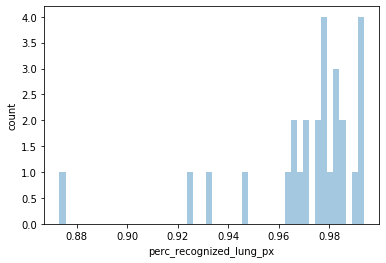

In [0]:
sns.distplot(df_test_pred.perc_recognized_lung_px, kde=False, rug=False, bins=50)
plt.ylabel('count')
plt.show()

**Predicted lung area vs Real lung area**

In [0]:
pred_lung_area = df_test_pred.recognized_lung_px + (df_test_pred.true_background_px - df_test_pred.recognized_background_px)
df_test_pred['diff_lung_area_px'] = df_test_pred.true_lung_px - pred_lung_area
df_test_pred['perc_lung_area_error'] = df_test_pred.diff_lung_area_px/df_test_pred.true_lung_px

abs_diff_lung_area = np.abs(df_test_pred['diff_lung_area_px'])
print(f'Mean predicted lung area error: {np.mean(abs_diff_lung_area):.2f} ({np.mean(abs_diff_lung_area/df_test_pred.true_lung_px):.2%})')
print(f'Standard deviation predicted lung area error: {np.std(abs_diff_lung_area):.2f} ({np.std(abs_diff_lung_area/df_test_pred.true_lung_px):.2%})')

Mean predicted lung area error: 713.04 (5.30%)
Standard deviation predicted lung area error: 477.54 (4.12%)


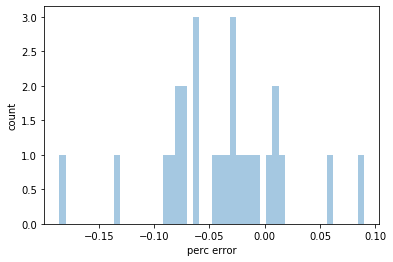

In [0]:
sns.distplot(df_test_pred['perc_lung_area_error'], kde=False, rug=False, bins=50)
plt.xlabel('perc error')
plt.ylabel('count')
plt.show()

### Examples of Predictions

**Random Images**

Found 27 validated image filenames.
Found 27 validated image filenames.


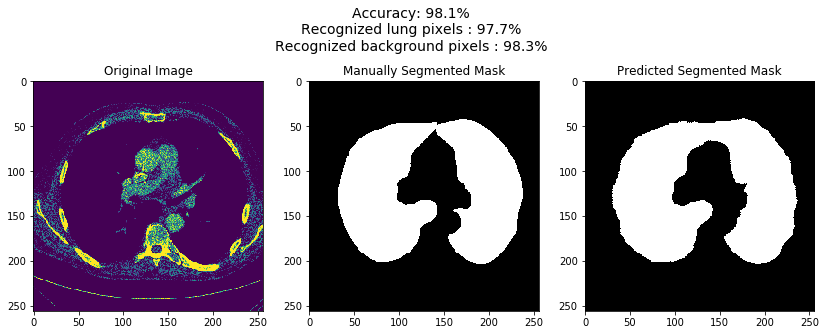

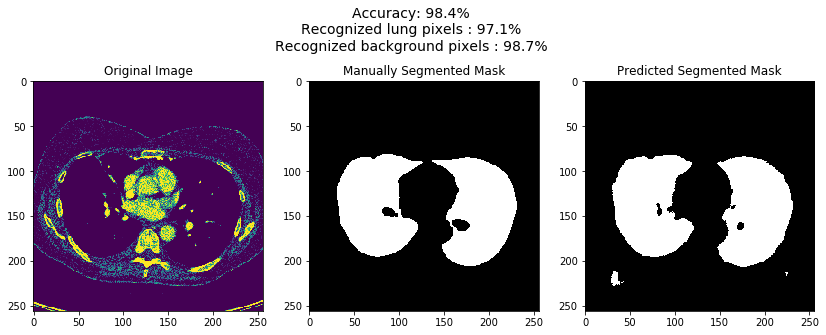

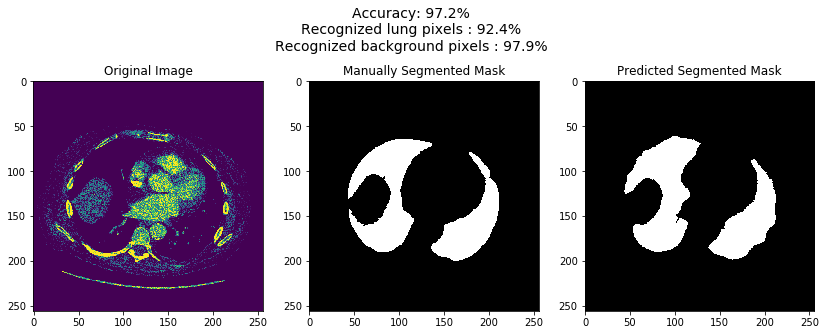

In [0]:
# Input and Ground Truth (using valid_generator for shuffle)
image_batch, mask_batch = next(valid_generator(df_test, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)))

# Predicted mask
mask_pred = model.predict(image_batch)

# Round all values to 0 or 1
mask_pred_round = np.round(mask_pred)

for i in range(3):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 5.5))

    ax[0].imshow(image_batch[i, :, :, 0])
    ax[0].set_title('Original Image')

    ax[1].imshow(mask_batch[i, :, :, 0], cmap='gray')
    ax[1].set_title('Manually Segmented Mask')

    ax[2].imshow(mask_pred_round[i, :, :, 0], cmap='gray')
    ax[2].set_title('Predicted Segmented Mask')
    
    # Miss Match result: 
    # 99  = right prediction  (lung)
    # 0   = right prediction  (background)
    # 100 = bad prediction    (lung)
    # -1  = bad prediction    (background)
    miss_match = 100*mask_batch[i, :, :, 0] - mask_pred_round[i, :, :, 0]
    values, count = np.unique(miss_match, return_counts=True)
    value_counts = {key: val for key, val in zip(values, count)}
    text0 = f'Accuracy: {(value_counts[99]+value_counts[0])/sum(value_counts.values()):.1%}'
    text1 = f'Recognized lung pixels : {value_counts[99]/(value_counts[99] + value_counts[100]):.1%}'
    text2 = f'Recognized background pixels : {value_counts[0]/(value_counts[0] + value_counts[-1]):.1%}'

    fig.suptitle(f'{text0}\n{text1}\n{text2}', fontsize=14)
    plt.show()

**Worst Recognized Lung Predictions**

Found 4 validated image filenames.
Found 4 validated image filenames.


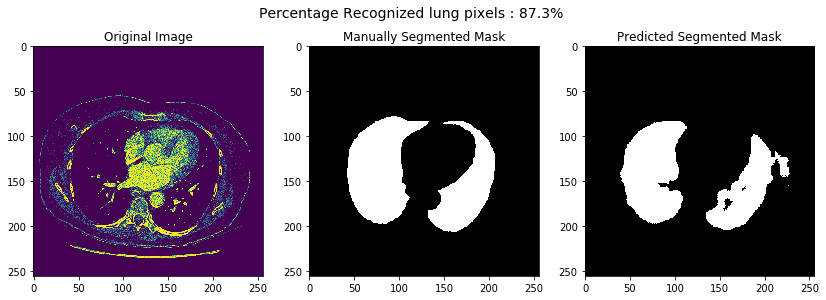

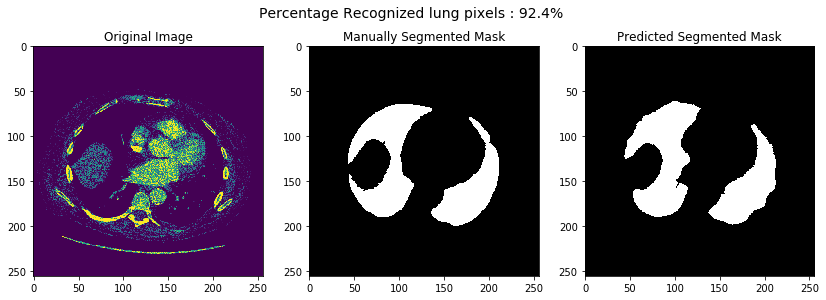

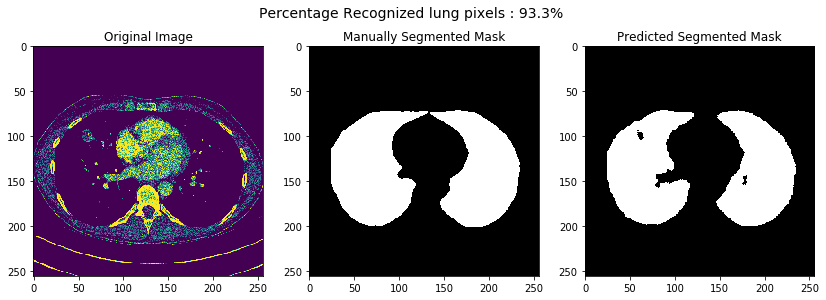

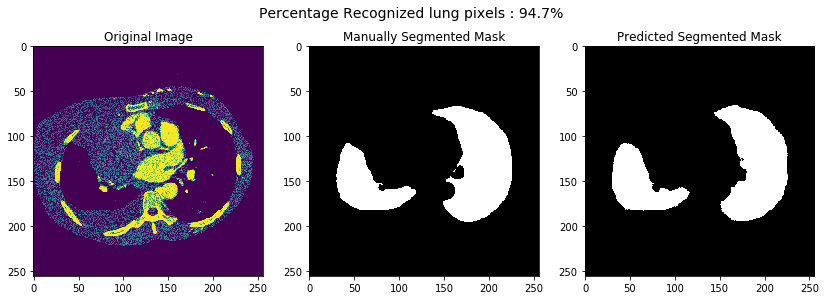

In [0]:
df_test_pred_worst = df_test_pred.query('perc_recognized_lung_px < 0.95').sort_values(by='perc_recognized_lung_px')

idx = 0
for img, mask in test_generator(df_test_pred_worst, batch_size=1, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    # Predict
    mask_pred = model.predict(img)

    # Trasfom images to the right size
    img = img[0, : , :, 0]
    mask = mask[0, : , :, 0]
    mask_pred = mask_pred[0, : , :, 0]

    # Round all values to 0 or 1
    mask_pred = np.round(mask_pred)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5))

    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Manually Segmented Mask')

    ax[2].imshow(mask_pred, cmap='gray')
    ax[2].set_title('Predicted Segmented Mask')
    
    text = f'Percentage recognized lung pixels : {df_test_pred_worst.iloc[idx].perc_recognized_lung_px:.1%}'
    fig.suptitle(text, fontsize=14)
    plt.show()


    # Generator will loop until stopped
    idx += 1
    if idx >= len(df_test_pred_worst):
        break

**Worst Lung Area Predictions**

Found 5 validated image filenames.
Found 5 validated image filenames.


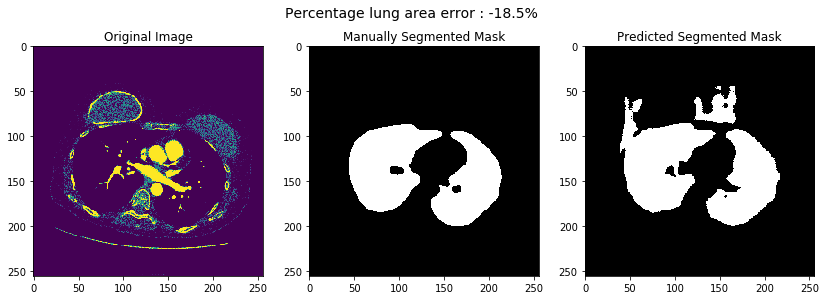

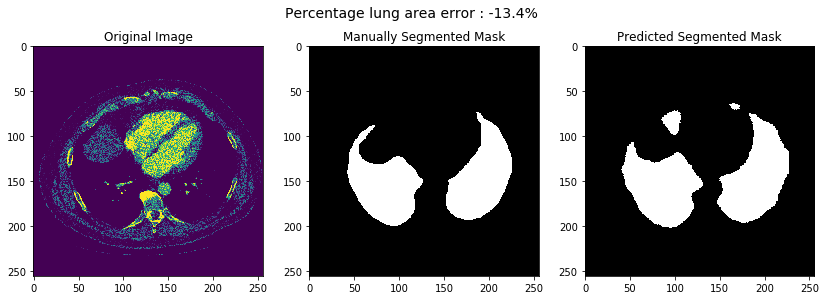

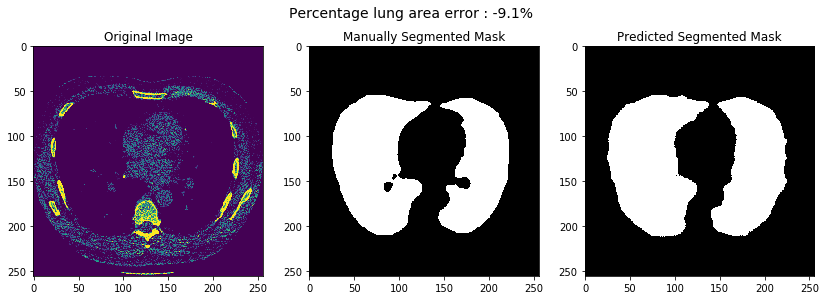

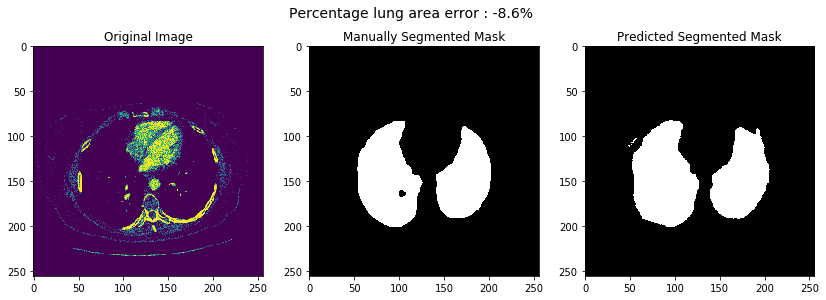

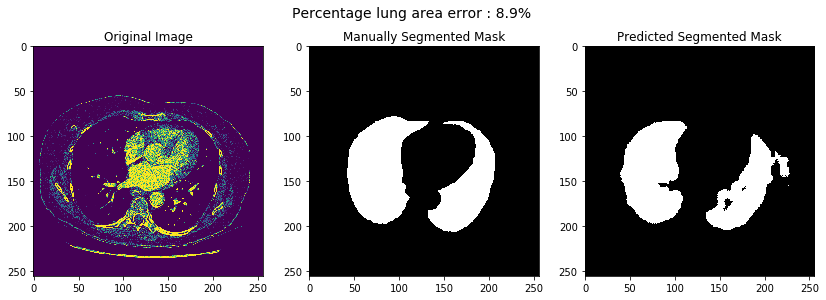

In [0]:
df_test_pred_worst = df_test_pred.loc[df_test_pred['perc_lung_area_error'].abs() > 0.08].sort_values(by='perc_lung_area_error')

idx = 0
for img, mask in test_generator(df_test_pred_worst, batch_size=1, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    # Predict
    mask_pred = model.predict(img)

    # Trasfom images to the right size
    img = img[0, : , :, 0]
    mask = mask[0, : , :, 0]
    mask_pred = mask_pred[0, : , :, 0]

    # Round all values to 0 or 1
    mask_pred = np.round(mask_pred)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5))

    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Manually Segmented Mask')

    ax[2].imshow(mask_pred, cmap='gray')
    ax[2].set_title('Predicted Segmented Mask')
    
    text = f'Percentage lung area error : {df_test_pred_worst.iloc[idx].perc_lung_area_error:.1%}'
    fig.suptitle(text, fontsize=14)
    plt.show()


    # Generator will loop until stopped
    idx += 1
    if idx >= len(df_test_pred_worst):
        break